In [536]:
#Import Packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import pandas_ta as pta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

# Data Setup

In [537]:
#Create dataframe 
ogdata = pd.read_csv('Smarket.csv')
ogdata.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [538]:
#Create Price variable in order to create RSI(stock market indicator) variable 
#RSI is a 14 day moving average so we have to remove the first 13 rows
ogdata["Price"] = 0
ogdata['Price'] = ogdata['Price'].astype(float)
ogdata["Price"][0] = 1335.63
for i in range(1,1250):
    ogdata["Price"][i] = ogdata["Price"][i-1] * (1 + ogdata["Today"][i]/100)
ogdata["RSI"] = pta.rsi(ogdata['Price'], length = 14)
data = ogdata.iloc[14: , :]

In [539]:
#Split data into training and test sets
#The models train on 2001-2004 and test on 2005
train = data[(data["Year"] < 2005)]
test = data[(data["Year"] == 2005)]
train_y = train["Direction"]
test_y = test["Direction"]
fullvars = ["RSI","Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]

# Logistic Regression

In [540]:
#Create function to run logistic regression on training data and output test error rate
def logregerror(train_x,train_y,test_x,test_y):
    model = LogisticRegression(solver='liblinear', random_state=0).fit(train_x,train_y)
    predictions = model.predict(test_x)
    error_rate = sum(predictions != test_y)/252
    return error_rate

In [541]:
#Run logistic regressions starting with all variables and remove the variables with the least importance
logerrorlist = []
for i in reversed(range(1,8)):
    logerrorlist.append(logregerror(train[fullvars[0:i]],train_y,test[fullvars[0:i]],test_y))
logminerror = min(logerrorlist)
logminerrorindex = logerrorlist.index(logminerror)

In [542]:
#Create output dataframe to compare test error rates between specifications
dict = {' ' : ["Error Rate:"],
        'Model 1' : [logerrorlist[6]],
        'Model 2' : [logerrorlist[5]],
        'Model 3' : [logerrorlist[4]],
        'Model 4' : [logerrorlist[3]],
        'Model 5' : [logerrorlist[2]],
        'Model 6' : [logerrorlist[1]],
        'Model 7' : [logerrorlist[0]],}
logtable = pd.DataFrame(dict).set_index(' ')
logtable

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
,,,,,,,
Error Rate:,0.365079,0.333333,0.333333,0.325397,0.325397,0.321429,0.337302


In [543]:
print(f"The logistic model that gives the smallest error is Model {7 - logminerrorindex} and that error is {logminerror}")

The logistic model that gives the smallest error is Model 6 and that error is 0.32142857142857145


[[102  39]
 [ 42  69]]


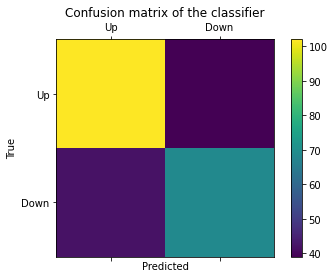

In [544]:
#Output confusion matrix to see what kind of errors the model is making
labels = ['Up', 'Down']
cm = confusion_matrix(test_y, bestpredictions, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [545]:
#Create a classification report to see the accuracy of the model within each class
bestmodel = LogisticRegression(solver='liblinear', random_state=0).fit(train[fullvars[0:6]],train_y)
bestpredictions = bestmodel.predict(test[fullvars[0:6]])
print(classification_report(test_y, bestpredictions))

              precision    recall  f1-score   support

        Down       0.64      0.62      0.63       111
          Up       0.71      0.72      0.72       141

    accuracy                           0.68       252
   macro avg       0.67      0.67      0.67       252
weighted avg       0.68      0.68      0.68       252



# Linear Discriminant Analysis (LDA)

In [546]:
#Create function to run LDA on training data and output test error rate
def LDAerror(train_x,train_y,test_x,test_y):
    model = LinearDiscriminantAnalysis(solver='lsqr').fit(train_x,train_y)
    predictions = model.predict(test_x)
    error_rate = sum(predictions != test_y)/252
    return error_rate

In [547]:
#Run LDA starting with all variables and remove the variables with the least importance
LDAerrorlist = []
for i in reversed(range(1,8)):
    LDAerrorlist.append(LDAerror(train[fullvars[0:i]],train_y,test[fullvars[0:i]],test_y))
LDAminerror = min(LDAerrorlist)
LDAminerrorindex = LDAerrorlist.index(LDAminerror)

In [548]:
#Create output dataframe to compare test error rates between specifications
dict = {' ' : ["Error Rate:"],
        'Model 1' : [LDAerrorlist[6]],
        'Model 2' : [LDAerrorlist[5]],
        'Model 3' : [LDAerrorlist[4]],
        'Model 4' : [LDAerrorlist[3]],
        'Model 5' : [LDAerrorlist[2]],
        'Model 6' : [LDAerrorlist[1]],
        'Model 7' : [LDAerrorlist[0]],}
LDAtable = pd.DataFrame(dict).set_index(' ')
LDAtable

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
,,,,,,,
Error Rate:,0.373016,0.333333,0.329365,0.325397,0.329365,0.321429,0.31746


In [549]:
print(f"The LDA model that gives the smallest error is Model {7 - LDAminerrorindex} and that error is {LDAminerror}")

The LDA model that gives the smallest error is Model 7 and that error is 0.31746031746031744


In [550]:
#Create a classification report to see the accuracy of the model within each class
bestmodelLDA = LinearDiscriminantAnalysis(solver='lsqr').fit(train[fullvars[0:7]],train_y)
bestpredictionsLDA = bestmodelLDA.predict(test[fullvars[0:7]])
print(classification_report(test_y, bestpredictionsLDA))

              precision    recall  f1-score   support

        Down       0.64      0.62      0.63       111
          Up       0.71      0.73      0.72       141

    accuracy                           0.68       252
   macro avg       0.68      0.68      0.68       252
weighted avg       0.68      0.68      0.68       252



[[103  38]
 [ 42  69]]


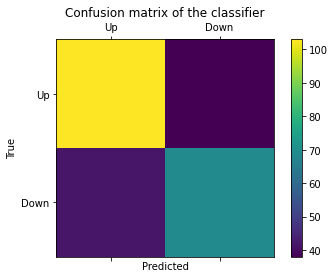

In [551]:
#Output confusion matrix to see what kind of errors the model is making
labels = ['Up', 'Down']
cm = confusion_matrix(test_y, bestpredictionsLDA, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Quadratic Discriminant Analysis (QDA)

In [552]:
#Create function to run QDA on training data and output test error rate
def QDAerror(train_x,train_y,test_x,test_y):
    model = QuadraticDiscriminantAnalysis().fit(train_x,train_y)
    predictions = model.predict(test_x)
    error_rate = sum(predictions != test_y)/252
    return error_rate

In [553]:
#Run QDA starting with all variables and remove the variables with the least importance
QDAerrorlist = []
for i in reversed(range(1,8)):
    QDAerrorlist.append(QDAerror(train[fullvars[0:i]],train_y,test[fullvars[0:i]],test_y))
QDAminerror = min(QDAerrorlist)
QDAminerrorindex = QDAerrorlist.index(QDAminerror)

In [554]:
#Create output dataframe to compare test error rates between specifications
dict = {' ' : ["Error Rate:"],
        'Model 1' : [QDAerrorlist[6]],
        'Model 2' : [QDAerrorlist[5]],
        'Model 3' : [QDAerrorlist[4]],
        'Model 4' : [QDAerrorlist[3]],
        'Model 5' : [QDAerrorlist[2]],
        'Model 6' : [QDAerrorlist[1]],
        'Model 7' : [QDAerrorlist[0]],}
QDAtable = pd.DataFrame(dict).set_index(' ')
QDAtable

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
,,,,,,,
Error Rate:,0.365079,0.333333,0.333333,0.325397,0.337302,0.333333,0.369048


In [555]:
print(f"The QDA model that gives the smallest error is Model {7 - QDAminerrorindex} and that error is {QDAminerror}")

The QDA model that gives the smallest error is Model 4 and that error is 0.3253968253968254


In [556]:
#Create a classification report to see the accuracy of the model within each class
bestmodelQDA = QuadraticDiscriminantAnalysis().fit(train[fullvars[0:4]],train_y)
bestpredictionsQDA = bestmodelQDA.predict(test[fullvars[0:4]])
print(classification_report(test_y, bestpredictionsQDA))

              precision    recall  f1-score   support

        Down       0.64      0.59      0.62       111
          Up       0.70      0.74      0.72       141

    accuracy                           0.67       252
   macro avg       0.67      0.67      0.67       252
weighted avg       0.67      0.67      0.67       252



[[104  37]
 [ 45  66]]


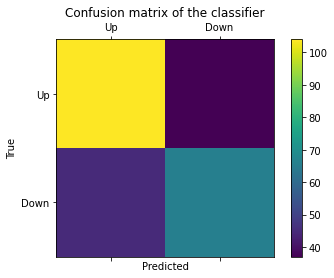

In [557]:
#Output confusion matrix to see what kind of errors the model is making
labels = ['Up', 'Down']
cm = confusion_matrix(test_y, bestpredictionsQDA, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# K-Nearest Neighbors

In [558]:
knnerrors = []
for i in range(1,300):
    model = KNeighborsClassifier(n_neighbors=i).fit(train_x, train_y)
    predictions = model.predict(test_x)
    knnerrors.append(sum(predictions != test_y)/252)
knnminerror = min(knnerrors)

In [559]:
print(f"The value of k that gives the smallest error is {knnerrors.index(knnminerror) + 1} and that error is {knnminerror}")

The value of k that gives the smallest error is 286 and that error is 0.3333333333333333


In [560]:
#Create a classification report to see the accuracy of the model within each class
bestmodelknn = KNeighborsClassifier(n_neighbors=285).fit(train_x, train_y)
bestpredictionsknn = bestmodelknn.predict(test_x)
print(classification_report(test_y, bestpredictionsknn))

              precision    recall  f1-score   support

        Down       0.63      0.53      0.58       111
          Up       0.67      0.76      0.71       141

    accuracy                           0.66       252
   macro avg       0.65      0.65      0.65       252
weighted avg       0.66      0.66      0.65       252



[[107  34]
 [ 52  59]]


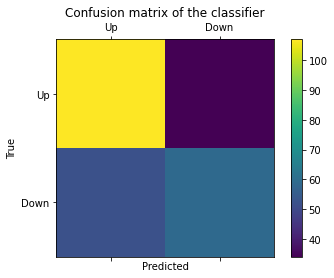

In [561]:
labels = ['Up', 'Down']
cm = confusion_matrix(test_y, bestpredictionsknn, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model Comparison

In [562]:
minerrorlist = [logminerror,LDAminerror,QDAminerror,knnminerror]
#Create output dataframe to compare test error rates between specifications
dict = {' ' : ["Error Rate:"],
        'Logistic Reg' : [logminerror],
        'LDA' : [LDAminerror],
        'QDA' : [QDAminerror],
        'KNN' : [knnminerror]}
finaltable = pd.DataFrame(dict).set_index(' ')
finaltable

,Logistic Reg,LDA,QDA,KNN
,,,,
Error Rate:,0.321429,0.31746,0.325397,0.333333
